In [2]:
import MDAnalysis as mda
import os
import matplotlib.pyplot as plt
import circle_fit as cf
%matplotlib inline

In [3]:
current_directory = os.getcwd()
current_directory = str(current_directory)[:59]
data_files_directory_name = 'DataFiles'

graphene_water_psf = os.path.join(current_directory, data_files_directory_name, 'graphene_water.psf')
ns_graphene_water_dcd = os.path.join(current_directory, data_files_directory_name, '1ns.dcd')

#print(f'{graphene_water_psf} \n {ns_graphene_water_dcd}')

In [4]:
u = mda.Universe(graphene_water_psf,ns_graphene_water_dcd)

uni_SPCE = u.select_atoms('resname SPCE')
pos = uni_SPCE.positions

c:\Users\drews\AppData\Local\Programs\Python\Python312\Lib\site-packages\MDAnalysis\coordinates\DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [5]:
filtered_pos = {'x_val': [], 'y_val': [],'z_val': []}

# Cutting data in half
for coord in pos:
    if coord[0] >= 0 and coord[1] >= 0 and coord[2] >= 0:
        filtered_pos['x_val'].append(coord[0])
        filtered_pos['y_val'].append(coord[1])
        filtered_pos['z_val'].append(coord[2])

In [6]:
print(len(filtered_pos['x_val']))

6080


In [7]:
percent_partition = .05
y_partition,z_partition = [],[]

y_max = max(filtered_pos['y_val'])
z_max = max(filtered_pos['z_val'])
x_length = max(filtered_pos['x_val']) - min(filtered_pos['x_val'])

h2o_mass_amu = 18.016
h2o_mass_SI = 2.99162692e-26

partition_volume_default_units = y_max * z_max * x_length
partition_volume_SI_units = partition_volume_default_units * 1e-10 * 1.66054e-27

for i in range(int(1/percent_partition)):
    y_partition.append(y_max * percent_partition * i)

for i in range(int(1/percent_partition)):
    z_partition.append(z_max * percent_partition * i)

y_partition_SI = [i * 1e-10 for i in y_partition]
z_partition_SI = [i * 1e-10 for i in z_partition]

# Creation of y & z partition. Think of it like the reiman sum delta x's

In [8]:
y_partitioned_pos = {}

for i in range(len(y_partition)): # For each partition in our y_partition | which should have a total of 20

    y_partitioned_pos[i] = {'x_val': [], 'y_val': [],'z_val': []}
    for j in range(len(filtered_pos['x_val'])): # For every atom in our set | Which when halved we should have 6080 atoms
        
        try:
            if filtered_pos['y_val'][j] >= y_partition[i] and filtered_pos['y_val'][j] <= y_partition[i+1]: # If sorted atom is at any x,z val in our y_partition, add to new dict
                y_partitioned_pos[i]['x_val'].append(filtered_pos['x_val'][j])
                y_partitioned_pos[i]['y_val'].append(filtered_pos['y_val'][j])
                y_partitioned_pos[i]['z_val'].append(filtered_pos['z_val'][j])

        except IndexError: # If our atom location is past our final partition, that is still expected and such the data is appended to a theoretical further one
            y_partitioned_pos[i]['x_val'].append(filtered_pos['x_val'][j])
            y_partitioned_pos[i]['y_val'].append(filtered_pos['y_val'][j])
            y_partitioned_pos[i]['z_val'].append(filtered_pos['z_val'][j])

In [9]:
fully_partitioned_coords = {}

# Creation of the structure of our dictionary that we will be sorting our atoms into

for i in range(int(1/percent_partition)): # Creating our y partitions
    fully_partitioned_coords[i] = {}

    for j in range(int(1/percent_partition)): # Creating our z partitions that we will eventually add atomic coords to
        fully_partitioned_coords[i][j] = {'x_val':[],'y_val':[],'z_val':[]}


for i_dist in range(len(y_partition)): # Iterating through each y partition until we go through each height partition
    for i_height in range(len(z_partition)): # Iterating through each z partition
        for i_atom in range(len(y_partitioned_pos[i_dist]['z_val'])): # Looping through all our atoms and asking them, are you in this y partition and this z partition

            try: 
                if z_partition[i_height] <= y_partitioned_pos[i_dist]['z_val'][i_atom] and y_partitioned_pos[i_dist]['z_val'][i_atom] <= z_partition[i_height + 1]:
                    fully_partitioned_coords[i_dist][i_height]['x_val'].append(y_partitioned_pos[i_dist]['x_val'][i_atom])
                    fully_partitioned_coords[i_dist][i_height]['y_val'].append(y_partitioned_pos[i_dist]['y_val'][i_atom])
                    fully_partitioned_coords[i_dist][i_height]['z_val'].append(y_partitioned_pos[i_dist]['z_val'][i_atom])

            except IndexError:
                fully_partitioned_coords[i_dist][i_height]['x_val'].append(y_partitioned_pos[i_dist]['x_val'][i_atom])
                fully_partitioned_coords[i_dist][i_height]['y_val'].append(y_partitioned_pos[i_dist]['y_val'][i_atom])
                fully_partitioned_coords[i_dist][i_height]['z_val'].append(y_partitioned_pos[i_dist]['z_val'][i_atom])

In [10]:
density_partition = {}
for i in range(len(fully_partitioned_coords.keys())): # Creating structure that we will append our densities to eventually.
    density_partition[i] = []

# Density partition takes form of {0:[],1:[],...} where key represents the y_partition and the lists represent the z_partitions which the densities will be stored in
# These z_partitions are assuming from bottom z to top z

In [11]:
for i in range(len(fully_partitioned_coords.keys())): # Iterating through each y partition in our fulpartitioned dict
    for j in range(len(fully_partitioned_coords[i].keys())): # Iterating through each z partition in our fulpartitioned dict

        #density = len(fully_partitioned_coords[i][j]['x_val']) * h2o_mass_SI / (partition_volume_SI_units) # kg / m^3
        density_partition[i].append(len(fully_partitioned_coords[i][j]['x_val'])) # Writing the amount of atoms in said (y,z) partition into the density array

Text(0, 0.5, 'Y Partition (Å)')

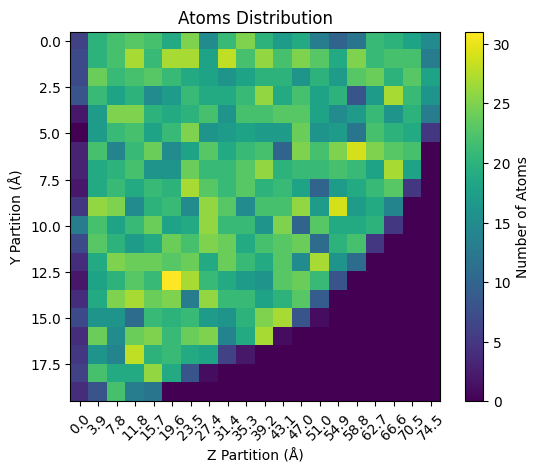

In [23]:

data = {
    0: [6, 20, 22, 23, 22, 19, 25, 15, 21, 25, 20, 17, 19, 13, 10, 12, 21, 20, 18, 15],
    1: [7, 20, 22, 27, 21, 27, 27, 18, 28, 22, 26, 22, 25, 23, 19, 25, 21, 22, 22, 13],
    2: [7, 24, 21, 22, 23, 21, 19, 18, 16, 18, 20, 20, 16, 20, 17, 23, 24, 20, 23, 18],
    3: [8, 21, 18, 20, 15, 17, 21, 19, 19, 21, 26, 19, 22, 18, 20, 8, 17, 27, 21, 16],
    4: [2, 17, 25, 25, 20, 19, 20, 22, 16, 22, 22, 23, 23, 18, 15, 17, 21, 16, 20, 13],
    5: [0, 17, 21, 22, 18, 21, 25, 16, 17, 18, 17, 17, 24, 16, 17, 12, 22, 20, 19, 5],
    6: [3, 22, 14, 21, 24, 15, 18, 23, 19, 21, 22, 10, 25, 22, 25, 29, 25, 23, 22, 0],
    7: [3, 19, 20, 22, 16, 16, 24, 21, 21, 23, 26, 20, 21, 21, 22, 21, 18, 27, 18, 0],
    8: [2, 19, 21, 19, 21, 20, 27, 23, 21, 23, 20, 21, 18, 10, 17, 19, 21, 23, 5, 0],
    9: [5, 26, 25, 15, 20, 21, 15, 26, 23, 15, 22, 22, 26, 17, 29, 17, 19, 14, 0, 0],
    10: [13, 22, 18, 21, 24, 18, 19, 26, 21, 21, 16, 25, 10, 23, 19, 19, 20, 5, 0, 0],
    11: [7, 23, 20, 17, 19, 24, 22, 25, 24, 19, 22, 23, 24, 11, 20, 22, 5, 0, 0, 0],
    12: [4, 19, 25, 24, 24, 23, 24, 19, 24, 21, 19, 23, 15, 27, 16, 11, 0, 0, 0, 0],
    13: [2, 18, 20, 23, 21, 31, 27, 21, 19, 17, 16, 23, 24, 21, 8, 0, 0, 0, 0, 0],
    14: [4, 19, 25, 27, 24, 25, 13, 26, 21, 21, 18, 20, 23, 9, 0, 0, 0, 0, 0, 0],
    15: [7, 16, 16, 11, 21, 20, 21, 17, 16, 20, 25, 27, 8, 1, 0, 0, 0, 0, 0, 0],
    16: [4, 24, 15, 24, 25, 21, 24, 25, 14, 19, 27, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    17: [5, 16, 14, 28, 20, 21, 19, 18, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    18: [6, 22, 19, 19, 26, 19, 8, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    19: [4, 8, 22, 13, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
}

# Custom tick values and labels for y-axis
y_ticks = [i*3.837737274169922 for i in range(len(data))]
y_labels = [f'{i:.1f}' for i in y_ticks]

# Custom tick values and labels for x-axis
z_ticks = [i*3.9192962646484375 for i in range(len(data[0]))]
z_labels = [f'{i:.1f}' for i in z_ticks]

# Convert dictionary to 2D list
matrix = [[data[y][z] for z in range(len(data[0]))] for y in range(len(data))]

plt.imshow(matrix)

#plt.xticks(range(len(z_ticks)), z_labels, rotation=45)  # Rotate x-axis labels by 45 degrees
#plt.yticks(range(len(y_ticks)), y_labels)

plt.title('Atoms Distribution')
plt.colorbar(label='Number of Atoms')
plt.xlabel('Z Partition (Å)')
plt.ylabel('Y Partition (Å)')


In [13]:
first_height = data[0]
ph_index = []

for index in range(len(data.keys())):
    for i in range(len(first_height)):
        if data[index][-i-1] < 18 and data[index][-i-2] >= 18:
            ph_index.append(-i-2)
            break
        elif data[index][-1] >= 18:
            ph_index.append(-1)
            break

actual_y_vals = []
actual_x_vals = []
for i in range(len(ph_index)):
    actual_y_vals.append(21 + ph_index[i])
    actual_x_vals.append(i)

furthest_coord_pos = []
for i in range(len(actual_y_vals)):
    furthest_coord_pos.append((round(actual_x_vals[i] * y_max * percent_partition, 1), round(actual_y_vals[i] * z_max * percent_partition, 1)))


print(furthest_coord_pos)



[(0.0, 74.5), (3.8, 74.5), (7.7, 78.4), (11.5, 74.5), (15.4, 74.5), (19.2, 74.5), (23.0, 74.5), (26.9, 74.5), (30.7, 70.5), (34.5, 66.6), (38.4, 66.6), (42.2, 62.7), (46.1, 54.9), (49.9, 54.9), (53.7, 51.0), (57.6, 47.0), (61.4, 43.1), (65.2, 31.4), (69.1, 23.5), (72.9, 11.8)]


In [14]:
#for i in range(len(furthest_coord_pos)):
#    print([furthest_coord_pos[2*i],furthest_coord_pos[(2*i+1)]])

In [15]:

xc,yc,r,_ = cf.least_squares_circle(furthest_coord_pos)
point_coordinates = [[1, 0], [-1, 0], [0, 1], [0, -1]]
print(round(xc,2),round(yc,2),round(r,2))

-0.77 3.98 72.63
